# Modeling
### Goal: Compare different regression models, including linear models & tree-based models
#### Last updated by Lindsay Warrenburg, Feb. 7, 2020

# Step 1. Set-Up
### Import packages and change working directory

In [3]:
import pandas as pd
import numpy as np
import os
import sys
import ipywidgets as widgets
import qgrid
import xlrd
import xgboost as xgb
import matplotlib.pyplot as plt 
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
import shap
import pickle5 as pickle
from random_words import RandomWords
from merf import MERF
from merf.utils import MERFDataGenerator
from merf.merf import MERF
from sklearn import preprocessing, metrics
from sklearn.feature_selection import SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score, train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_squared_log_error, make_scorer, confusion_matrix, plot_confusion_matrix, classification_report
from pandas.api.types import CategoricalDtype
from jupyter_contrib_nbextensions.application import main
from ipywidgets import interact
from plotnine import *
from plotnine.data import mpg
from IPython.display import HTML
from IPython.display import IFrame
from IPython.display import YouTubeVideo
from imblearn.over_sampling import SMOTE
%matplotlib inline

# set directory
os.chdir("/Users/home/Desktop/Data Science/Keep-Me-Engaged")
print(os.getcwd())

/Users/home/Desktop/Python/Insight/Keep-Me-Engaged


### Make View tab
#### Taken from Martin: https://stackoverflow.com/users/2575273/martin

In [ ]:
def View(df):
    css = """<style>
    table { border-collapse: collapse; border: 3px solid #eee; }
    table tr th:first-child { background-color: #eeeeee; color: #333; font-weight: bold }
    table thead th { background-color: #eee; color: #000; }
    tr, th, td { border: 1px solid #ccc; border-width: 1px 0 0 1px; border-collapse: collapse;
    padding: 3px; font-family: monospace; font-size: 10px }</style>
    """
    s  = '<script type="text/Javascript">'
    s += 'var win = window.open("", "Title", "toolbar=no, location=no, directories=no, status=no, menubar=no, scrollbars=yes, resizable=yes, width=780, height=200, top="+(screen.height-400)+", left="+(screen.width-840));'
    s += 'win.document.body.innerHTML = \'' + (df.to_html() + css).replace("\n",'\\') + '\';'
    s += '</script>'
    return(HTML(s+css))

files = os.listdir(os.curdir)

### Read in Data

In [5]:
data = pd.read_csv('data.csv')
print("data: ", data.shape) # (30688, 26)

data_log = pd.read_csv('data_log.csv')
print("data_log: ", data_log.shape, "\n") # (30688, 26)

data:  (30688, 26)
data_log:  (30688, 26) 



# Step 2. Train/Test Split
### Non-logged Predictors

In [6]:
X = data[[
         # 1. Admin features
         'Price (dollars)', 
         'Discount (dollars)', 
         'Length of Course (hours)', 
         'Number of Users', 
         'Company Administrators (percent)', 
         'Company Instructors (percent)',
         'Company Learners (percent)',
         'Company Rating (average)',

         # 2. Learner features
         #'Visibility (# views)', 
         'Quiz Grade (average)', 
         'Completed Quizzes (percent)',

         # 3. Instructor features
         #'Surveys, Talleys, and Workbooks (percent)', 
         'Graded Assessment (percent)',
         'Not-Graded Assessment (percent)',
         'Content (percent)',
         'External (percent)',
         'Interactive (percent)',

         # 4. Website features
         'Uses SCORM (yes/no)', 
         'Milestone Course (yes/no)', 
         'Certificates (percent)',
         'Collaborations (average)', 
         'Teacher Comments (average)', 
]]

y = data['Engagement Score']


### Logged Predictors

In [ ]:
X_log = data_log[[
         # 1. Admin features
         'Price (dollars)', 
         'Discount (dollars)', 
         'Length of Course (hours)', 
         'Number of Users', 
         'Company Administrators (percent)', 
         'Company Instructors (percent)',
         'Company Learners (percent)',
         'Company Rating (average)',

         # 2. Learner features
         'Visibility (# views)', 
         'Quiz Grade (average)', 
         'Completed Quizzes (percent)',

         # 3. Instructor features
         'Surveys, Talleys, and Workbooks (percent)', 
         'Graded Assessment (percent)',
         'Not-Graded Assessment (percent)',
         'Content (percent)',
         'External (percent)',
         'Interactive (percent)',

         # 4. Website features
         'Uses SCORM (yes/no)', 
         'Milestone Course (yes/no)', 
         'Certificates (percent)',
         'Collaborations (average)', 
         'Teacher Comments (average)', 
]]

y_log = data_log['Engagement Score']


### Read out DF to CSV for Web App Use

In [19]:
X.to_csv(r'X.csv', index = None, header=True)
y.to_csv(r'y.csv', index = None, header=True)

### Choose Small of Companies/Courses for Web App Selection

In [ ]:
small = data.sort_values(by=['companyid_words'])
test = small.groupby('companyid_words').head(15)
counts = pd.DataFrame(test['companyid_words'].value_counts())
View(counts)
counts = counts[counts['companyid_words'] > 2]
counts.index

test = test[test['companyid_words'].isin(counts.index)]

test.to_csv(r'fifteen.csv', index = None, header=True)

# Step 3. Random Forest Regression

In [ ]:
### RANDOM FOREST MODELS: ###
    # selected because both categorical and continuous features
    # it treats rows more independently than linear regression:
    # linear regression assumes correlation (linear relation between e.g, engagment 
    # and quiz grade avg, are the same across all rows (courses). 
    # in random forest models, the impact of each feature on engagment is allowed to vary more
    # random forest regression bc y is continuous
    # supervised model

### Train/Test Split

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=int(100*np.random.random()))

### Hyper-parameter Tuning: Grid Search

In [8]:
# helps choose best hyperparameters. Also does validation automatically
    # n_estimators: # trees
    # max_features: max # features before splitting
    # max_depth = max # of levels for each tree (how many times it splits)
    # min_samples_split = min # data points used before split
    # min_samples_leaf = min # data points in a leaf
    # bootstrap = how sample data points

estimator = RandomForestRegressor()
parameter_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [200, 300, 1000, 1500]
}
rf = GridSearchCV(estimator, parameter_grid, cv = 3)
rf.fit(X_train, y_train)
    # bootstrapping = T: samples observations WITH replacement (keeps independence)
    # cv = # of cross-validation folds
    # fit: validation metric. extract the validation metrics.

# evaluate
# print(rf.cv_results_)
print('Best parameters found by grid search are:', rf.best_params_)
    # Best parameters found by grid search are: 
    # {'bootstrap': True, 'max_depth': 110, 'max_features': 3, 
    # 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1500}



Best parameters found by grid search are: {'bootstrap': True, 'max_depth': 110, 'max_features': 3, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 1500}


### Evaluating Base RF Model and RF with Hyperparameters Tuned
#### Taken from https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74

In [9]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    return accuracy

# base model (no tuning)
base_model = RandomForestRegressor(max_depth = 8, n_estimators = 20)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)
    # Base Model Performance
    # Average Error: 14.0688 degrees.
    # Accuracy = 34.59%.
    
# tuned model
tuned_parameter_grid = {
    'bootstrap': [True],
    'max_depth': [110],
    'max_features': [3],
    'min_samples_leaf': [3],
    'min_samples_split': [8],
    'n_estimators': [1500]
}

rf_tuned = GridSearchCV(estimator, tuned_parameter_grid, cv = 3)
rf_tuned.fit(X_train, y_train)

best_rf = rf_tuned.best_estimator_
random_accuracy = evaluate(best_rf, X_test, y_test)
    # Tuned Model Performance
    # Average Error: 11.9231 degrees.
    # Accuracy = 41.10%.
    # Improvement of 18.82%.

# check how much the tuned model increases accuracy
print('Improvement of {:0.2f}%.'.format( 100 * (random_accuracy - base_accuracy) / base_accuracy))
    # Improvement of 18.82%.

INFO     [utils.py:141] NumExpr defaulting to 8 threads.


Model Performance
Average Error: 14.0688 degrees.
Accuracy = 34.59%.
Model Performance
Average Error: 11.9231 degrees.
Accuracy = 41.10%.
Improvement of 18.82%.


### Run & Evaluate RF Model

Mean Absolute Error: 12.024816586679458
Mean Squared Error: 243.88620772290537
Root Mean Squared Error: 15.616856525015057
R2 of test set: 0.6160457370487651
R2 of training set--helps look for overfitting: 0.733271602345603


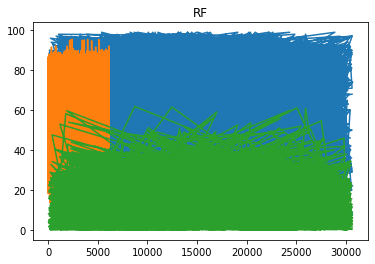

In [17]:
# take this model tuned above
regressor = RandomForestRegressor(bootstrap = True, max_depth = 110, max_features = 3,
                                  min_samples_leaf = 3, min_samples_split = 8, n_estimators=1500, 
                                  random_state=int(100*np.random.random()))

regressor.fit(X_train, y_train)
regressor.feature_importances_
y_pred = regressor.predict(X_test)

# evaluate    
    # MAE measures the average magnitude of the errors in a set of predictions
    # The Mean squared error (MSE) measures the mean squared error. 
    # Like MAE, the MSE treats deviations in either direction the same way. 
    # One difference between MSE and MAE is that MSE will tend to punish large errors more 
    # because it squares all the errors

    # RMSE is the square root of the average of squared differences between prediction and 
    # actual observation.
    # The RMSE gives a relatively high weight to large errors. 
    # This means the RMSE should be more useful when large errors are particularly undesirable.

mae = metrics.mean_absolute_error(y_test, y_pred)
mse = metrics.mean_squared_error(y_test, y_pred)
rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
rsq_test = regressor.score(X_test,y_test)
rsq_train = regressor.score(X_train,y_train)
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R2 of test set:', rsq_test)
print('R2 of training set--helps look for overfitting:', rsq_train)
    
# plot: x-axis is index.
plt.plot(y_test)
plt.plot(y_pred)
error = abs(y_test-y_pred)
plt.plot(error)
plt.title('RF')
plt.legend
plt.show()

# RESULTS
    # Mean Absolute Error: 11.919842757319413
    # Mean Squared Error: 239.69117328533193
    # Root Mean Squared Error: 15.48196283697038
    # R2 of test set: 0.619678548144315
    # R2 of training set--helps look for overfitting: 0.7328602018227833


### Read out model as a pickle file

In [22]:
filename = 'finalizedmodel.sav'
pickle.dump(regressor, open(filename, 'wb'))

### Feature Importance

Feature ranking:


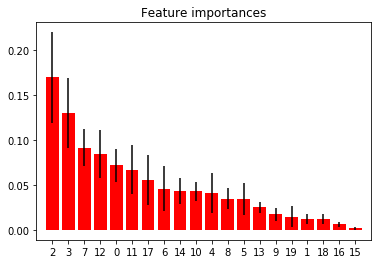

,colname,rank,importance,controllable
0,Length of Course (hours),2,0.169674,Administrative Features
1,Number of Users,3,0.130193,Administrative Features
2,Company Rating (average),7,0.091520,Administrative Features
3,Content (percent),12,0.084493,Instructor Features
4,Price (dollars),0,0.071583,Administrative Features
5,Not-Graded Assessment (percent),11,0.066813,Instructor Features
6,Certificates (percent),17,0.055398,Website Features
7,Company Learners (percent),6,0.045614,Administrative Features
8,Interactive (percent),14,0.043287,Instructor Features
9,Graded Assessment (percent),10,0.042690,Instructor Features


In [11]:
# feature importance
importances = regressor.feature_importances_
std = np.std([tree.feature_importances_ for tree in regressor.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
col = []
r = []
imp = []
for i in indices:
    column = X.columns[i]
    col.append(column)
    rank = i
    r.append(rank)
    importance = importances[i]
    imp.append(importance)
    
featureimportance = pd.DataFrame()
featureimportance['colname'] = col
featureimportance['rank'] = r
featureimportance['importance'] = imp
featureimportance = featureimportance.sort_values(by='importance', ascending = False)

# add column about whether or not the administrator can control those features
featureimportance['controllable'] = ""

for i, row in featureimportance.iterrows():
    if featureimportance.iloc[i, 0] in(['Price (dollars)', 'Discount (dollars)', 
                                        'Length of Course (hours)', 'Number of Users', 
                                        'Company Administrators (percent)', 
                                        'Company Instructors (percent)',
                                        'Company Learners (percent)',
                                        'Company Rating (average)']) :
        featureimportance.iloc[i, 3] = "Administrative Features"
        
    if featureimportance.iloc[i, 0] in (['Visibility (# views)', 'Quiz Grade (average)', 
                                         'Completed Quizzes (percent)']) :
        featureimportance.iloc[i, 3] = "Learner Features"
        
    if featureimportance.iloc[i, 0] in (['Surveys, Talleys, and Workbooks (percent)', 
                                         'Graded Assessment (percent)',
                                         'Not-Graded Assessment (percent)',
                                         'Content (percent)', 'External (percent)',
                                         'Interactive (percent)']) :
        featureimportance.iloc[i, 3] = "Instructor Features"
        
    if featureimportance.iloc[i, 0] in (['Uses SCORM (yes/no)', 
                                         'Milestone Course (yes/no)', 
                                         'Certificates (percent)',
                                         'Collaborations (average)', 
                                         'Teacher Comments (average)']) :
        featureimportance.iloc[i, 3] = "Website Features"
        
featureimportance.to_csv (r'featureimportance.csv', index = None, header=True)

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

featureimportance

### Plot Feature Importance

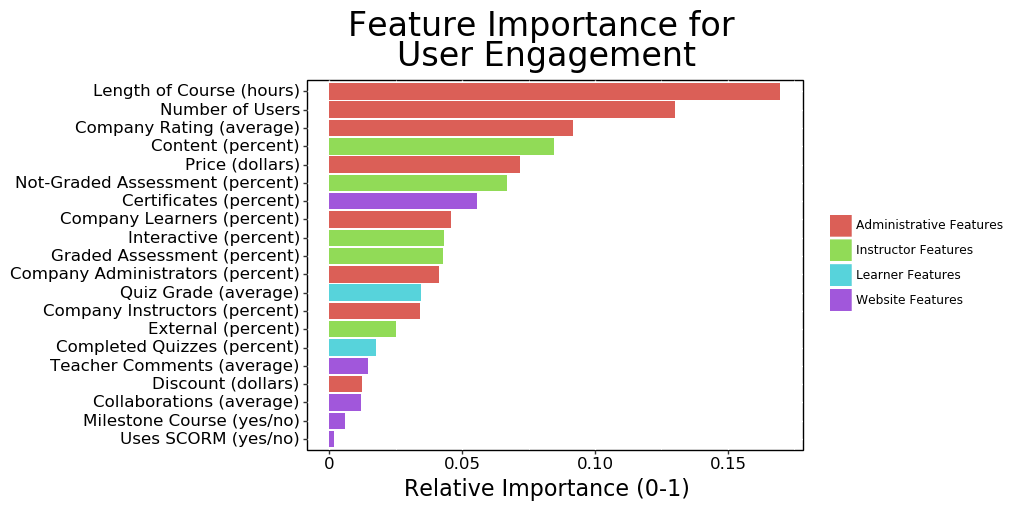

<ggplot: (7608075437)>

In [18]:
featureimportance = pd.read_csv('featureimportance.csv')

features = list(featureimportance['colname'])
featureimportance['colname'] = featureimportance['colname'].astype('category')

# bin list for all 4 types of features (instructor, website, administrative, learner)
bin_list = ['Length of Course (hours)', 'Number of Users', 'Company Rating (average)', 
            'Content (percent)', 'Price (dollars)', 'Not-Graded Assessment (percent)', 
            'Certificates (percent)', 'Company Learners (percent)', 
            'Interactive (percent)', 'Graded Assessment (percent)', 
            'Company Administrators (percent)', 'Quiz Grade (average)', 
            'Company Instructors (percent)', 'External (percent)', 
            'Completed Quizzes (percent)', 'Teacher Comments (average)', 
            'Discount (dollars)', 'Collaborations (average)', 
            'Milestone Course (yes/no)', 'Uses SCORM (yes/no)']

# repeat with only features a course instructor can control (instructor, website)
# featureimportance = featureimportance[featureimportance['controllable'].isin(['Instructor Features', 'Website Features'])]

# bin_list = ['Content (percent)', 'Not-Graded Assessment (percent)', 'Certificates (percent)', 
#             'Interactive (percent)', 'Graded Assessment (percent)', 'External (percent)', 
#             'Teacher Comments (average)', 'Collaborations (average)', 
#             'Milestone Course (yes/no)', 'Uses SCORM (yes/no)']

bin_cat = pd.Categorical(featureimportance['colname'], categories=bin_list)

# plot!
(
    ggplot(featureimportance, aes(x = 'bin_cat', y='importance', fill='controllable')) + 
    geom_bar(stat='identity', position='dodge')+
    xlab("") + ylab("Relative Importance (0-1)") +
    ggtitle("Feature Importance for \nUser Engagement") +
    coord_flip() + 
    scale_x_discrete(limits=list(reversed(bin_cat.categories))) +
    theme(
      axis_text_x = element_text(color = "black", size = 12, angle = 0),
      axis_text_y = element_text(color = "black", size = 12, angle = 0),
      legend_title=element_blank(),
      panel_grid_major = element_line(colour = "white"),
      panel_grid_minor = element_line(colour = "white"),
      panel_background = element_rect(fill = "white"),
      strip_background = element_rect(colour="black", fill="white"),
      axis_title_y = element_text(size = 16, angle = 90),
      axis_title_x = element_text(color = "black", size = 16, angle = 0),
      plot_title = element_text(size = 24, hjust = 0.5),
      strip_text = element_text(size = 16, face = "bold"),
      plot_background = element_rect(colour = "white"),
      panel_border = element_rect(colour = "black", fill = "white"))
)

### Shapley Values & Plots
#### Code and explanations of plots taken from https://github.com/slundberg/shap/blob/master/README.md

In [ ]:
#  Shapley value: average of marginal contributions across all permutations. 

# load JS visualization code to notebook
shap.initjs()

# explain the model's predictions using SHAP
explainer = shap.TreeExplainer(regressor)
shap_values = explainer.shap_values(X_train)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])
    # The above explanation shows features each c   ontributing to push the model output from the base value 
    # (the average model output over the training dataset we passed) to the model output. 
    # Features pushing the prediction higher are shown in red, 
    # those pushing the prediction lower are in blue

# To understand how a single feature effects the output of the model we can plot the SHAP 
    # value of that feature vs. the value of the feature for all the examples in a dataset. 
    # Since SHAP values represent a feature's responsibility for a change in the model output, 
    # the plot below represents the change in predicted house price as RM 
    # (the average number of rooms per house in an area) changes. 
    # Vertical dispersion at a single value of RM represents interaction effects with other features. 
    # To help reveal these interactions dependence_plot automatically selects another feature for coloring. 
    # In this case coloring by RAD (index of accessibility to radial highways) highlights that the 
    # average number of rooms per house has less impact on home price for areas with a high RAD value.

# create a dependence plot to show the effect of a single feature across the whole dataset
shap.dependence_plot("Uses SCORM (yes/no)", shap_values, X_train)

# To get an overview of which features are most important for a model we can plot the SHAP values 
    # of every feature for every sample. The plot below sorts features by the sum of SHAP value 
    # magnitudes over all samples, and uses SHAP values to show the distribution of the 
    # impacts each feature has on the model output. 
    # The color represents the feature value (red high, blue low). 
    # This reveals for example that a high LSTAT (% lower status of the population) lowers the predicted home price.

    # summarize the effects of all the features
shap.summary_plot(shap_values, X_train)

# We can also just take the mean absolute value of the SHAP values for each feature to get a standard bar plot 
# (produces stacked bars for multi-class outputs):
shap.summary_plot(shap_values, X_train, plot_type="bar")

# SHAP interaction values are a generalization of SHAP values to higher order interactions. 
    # Fast exact computation of pairwise interactions are implemented for tree models with the following code.
    # This returns a matrix for every prediction, where the main effects are on the diagonal and 
    # the interaction effects are off-diagonal. 
    # These values often reveal interesting hidden relationships, 
    # such as how the increased risk of death peaks for men at age 60
    
shap.TreeExplainer(regressor).shap_interaction_values(X_train)

# Step 4. Regression
### Linear Regression (Not-Logged Predictors)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f'Linear Regression_r2: {r2_score(y_test, y_pred).round(4)}')
print(f'Linear Regression_Mean_squared_error: {mean_squared_error(y_test, y_pred).round(4)}')

# RESULTS
    # Linear Regression_r2: 0.1324
    # Linear Regression_Mean_squared_error: 545.1472

### Linear Regression (Logged Predictors)

In [ ]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(f'Linear Regression_r2: {r2_score(y_test, y_pred).round(4)}')
print(f'Linear Regression_Mean_squared_error: {mean_squared_error(y_test, y_pred).round(4)}')

# RESULTS
    # Linear Regression_r2: 0.1556
    # Linear Regression_Mean_squared_error: 0.3781

### Regularized (Ridge) Regression, no tuning (Not-Logged Predictors)

In [ ]:
# looks for overimportant parameters
# alpha is a penalty term
    
rg = Ridge(alpha=1)
rg.fit(X_train, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=123)

print(f'Ridge Regression_r2: {rg.score(X_test, y_test).round(4)}')
cv_score = cross_val_score(rg, X, y, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_r2_Std_deviation: {cv_score.std().round(6)}')

# RESULTS
    # Ridge Regression_r2: 0.1322
    # Overall model performance with cv_Mean_r2: -0.034 
    # Overall model performance with cv_r2_Std_deviation: 0.31807

### Regularized (Ridge) Regression, no tuning (Logged Predictors)

In [ ]:
rg = Ridge(alpha=1)
rg.fit(X_train, y_train)

kf = KFold(n_splits=5, shuffle=True, random_state=123)

print(f'Ridge Regression_r2: {rg.score(X_test, y_test).round(4)}')
cv_score = cross_val_score(rg, X, y, cv=kf)
print(f'Overall model performance with cv_Mean_r2: {cv_score.mean().round(4)}', '\n'
f'Overall model performance with cv_r2_Std_deviation: {cv_score.std().round(6)}')

# RESULTS
    # Ridge Regression_r2: 0.1556
    # Overall model performance with cv_Mean_r2: -0.034 
    # Overall model performance with cv_r2_Std_deviation: 0.31807